# Compare Mannual curated model with the original model

In [1]:
import cobra
from cobra.io import read_sbml_model, load_json_model
import os
import pandas as pd

pd.set_option("display.max_columns", 20)

print(os.getcwd())

ext_dir = '/../../../data/external'
phenomics = '/../../phenomics'
gapfilling = '/../gapfilling'
mass_balance = '../4.mass_balance'

/Users/te/Library/CloudStorage/OneDrive-Personal/Biosustain/strep/Salb_GEM_Biosustain/notebooks/gapfilling/4.mass_balance


In [34]:
model_mass = read_sbml_model(f"{os.getcwd()}/{mass_balance}/Salb-GEM-Biosustain.xml")
model_ori = read_sbml_model(f"{os.getcwd()}/{ext_dir}/Salb-GEM-Updated.xml")

'' is not a valid SBML 'SId'.
'' is not a valid SBML 'SId'.


In [35]:
model_ori

Name,
Memory address,7f918e448150
Number of metabolites,1874
Number of reactions,2233
Number of genes,1386
Number of groups,0
Objective expression,1.0*growth - 1.0*growth_reverse_5ff58
Compartments,"Cytoplasm, Extracellular"


In [36]:
model_mass

Name,
Memory address,7f91cc379cd0
Number of metabolites,1886
Number of reactions,2270
Number of genes,1405
Number of groups,0
Objective expression,1.0*growth - 1.0*growth_reverse_5ff58
Compartments,"Cytoplasm, Extracellular"


# Calculate activity based on biolog data

In [37]:
# Mapping of bigg and biolog model
bigg_map_dir = os.getcwd() + ext_dir + "/" + "biolog_bigg_map.csv"
biolog_bigg_map = pd.read_csv(bigg_map_dir)

# Import processed biolog data based on DuctApe result
bio_data_dir = os.getcwd() + phenomics + "/" + 'phenome_J1074.tsv'
bio_data = pd.read_table(bio_data_dir)

In [38]:
# Join two tables together
bio_data.rename(columns={"#plate_id": "plate_id"}, inplace=True)
bio_data['index'] = bio_data['plate_id'] + "_" + bio_data['well_id']

biolog_bigg_map.rename(columns={"#plate_id": "plate_id"}, inplace=True)
bio_data_merged = bio_data.merge(biolog_bigg_map[['index', 'bigg', 'exchange']], on='index', how='left')

bio_data_merged

,plate_id,well_id,chemical,category,moa,co_id,replica,activity,min,max,height,plateau,slope,lag,area,source,index,bigg,exchange
0,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
1,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,2,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
2,PM01,A01,Negative Control,carbon,"C-Source, negative control",NaN,3,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,DuctApe,PM01_A01,#,#
3,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,1,9,0.1,230.173474,186.348403,230.400043,12.071765,1.053133,13196.559443,DuctApe,PM01_A02,arab__L,EX_arab__L_e
4,PM01,A02,L-Arabinose,carbon,"C-Source, carbohydrate",C00259,2,9,0.1,238.758221,193.692816,234.428667,23.269590,5.473487,13715.757651,DuctApe,PM01_A02,arab__L,EX_arab__L_e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,PM04,H11,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",C11145,2,0,0.1,8.549399,1.866640,0.000000,0.000000,0.000000,132.497394,DuctApe,PM04_H11,mso3,EX_mso3_e
1148,PM04,H11,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",C11145,3,0,0.1,6.706928,1.168076,1.085922,1.687639,0.591895,83.150410,DuctApe,PM04_H11,mso3,EX_mso3_e
1149,PM04,H12,Tetramethylene Sulfone,phosphate & sulphur,"S-Source, organic",NaN,1,0,0.1,26.160836,4.513821,0.000000,0.000000,0.000000,319.593733,DuctApe,PM04_H12,#,#
1150,PM04,H12,Tetramethylene Sulfone,phosphate & sulphur,"S-Source, organic",NaN,2,0,0.1,20.141574,4.671340,0.000000,0.000000,0.000000,328.952628,DuctApe,PM04_H12,#,#


In [39]:
# Find out the samples that grow or not grow based on activity and replicas
# Vote: >=3 = growth, >2/3 replicates = grow

def calculate_agreed_activity(bio_data, activity_cutoff=3, num_agreed_replicas=2):
    """
    Based on the activity data from the microarray experiment, using activity cutoff and
    agreed number replicates cutoff to make a dataframe that contains final activity info.
    
    Input:
    activity_cutoff: an integer between 0-9, if the activity is more than cutoff, it 
    means the strain grows.
    num_agreed_replicas: an integer, if the number of replicates agrees more than
    num_agreed_replicas times, it means the replicas agrees with the experimental result.
    
    Output:
    A dataframe that
    """
    agreed_bio_data = pd.DataFrame(columns=[
    'index', 'activity', 'chemical', 'category', 'moa', 'bigg', 'exchange'])
    
    # for each column 'index'
    for index, group in bio_data.groupby('index'):
        first_row = group.iloc[0]
        if (group['activity'] >= activity_cutoff).sum() >= num_agreed_replicas:
            agreed_bio_data = agreed_bio_data.append({'index': index, 
                                    'activity': True, 
                                    'chemical': first_row['chemical'], 
                                    'category':  first_row['category'], 
                                    'moa':  first_row['moa'],
                                    'bigg': first_row['bigg'],
                                    'exchange': first_row['exchange']}, ignore_index=True)
        else:
            agreed_bio_data = agreed_bio_data.append({'index': index, 
                                    'activity': False, 
                                    'chemical': first_row['chemical'], 
                                    'category':  first_row['category'], 
                                    'moa':  first_row['moa'],
                                    'bigg': first_row['bigg'],
                                    'exchange': first_row['exchange']}, ignore_index=True)
    return agreed_bio_data


activity_cutoff = 3
num_agreed_replicas = 2
agreed_bio_data = calculate_agreed_activity(bio_data_merged, activity_cutoff, num_agreed_replicas)

# Test model simulations functions

In [40]:
# Define media and model simulation functions
media = {
    "Biolog_base": {  # based on ecocyc
        "EX_cl_e": -1000,
        "EX_na1_e": -1000,
        "EX_nh4_e": -1000,
        "EX_pi_e": -1000,
        "EX_k_e": -1000,
        "EX_so4_e": -1000,
        "EX_mg2_e": -1000,
        "EX_fe2_e": -1000,
        # based on conditions, essentials and trace requirements
        "EX_o2_e": -1000,
        "EX_co2_e": -1000.0,
        "EX_h_e": -1000.0,
        "EX_mn2_e": -1000.0,
        "EX_zn2_e": -1000.0,
        "EX_ca2_e": -1000.0,
        "EX_ni2_e": -1000.0,
        "EX_cu2_e": -1000.0,
        "EX_cobalt2_e": -1000.0,
        "EX_h2o_e": -1000.0,
        "EX_mobd_e": -1000.0,
    },
    "C-Source": {},  # no further modification is needed
    "N-Source": {  # remove ammonia and add C-source
        "EX_nh4_e": 0,
        "EX_pyr_e": -20,
    },
    "P-Source": {  # remove phosphate and add C-source
        "EX_pi_e": 0,
        "EX_pyr_e": -20,
    },
    "S-Source": {  # remove sulfate and add C-source
        "EX_so4_e": 0,
        "EX_pyr_e": -20,
    },
}

def test_model_wrt_biolog(
    moa: str,
    additional_exchange: str,
    model: cobra.core.Model,
    media: dict = media,
    cutoff: float = 0.05,
):
    """
    Tests model with given media and returns True/False based on cutoff growth rate.
    If additional exchange reaction is not in the model, returns NaN.

    Input
    model: metabolic model
    moa: the mechanism of action of the biolog well test
    additional_exchange: the exchange reaction to be added to the model for the well
    media: a dictionary of media conditions to set for a given biolog test
    cutoff: the cutoff growth rate for boolean return

    Output
    True/False based on cutoff growth rate or NaN if additional exchange reaction is not
     in the model
    """
    # drop out quickly if there is no exchange reaction to use in the model
    if additional_exchange not in model.reactions:
        return float("nan")

    with model:
        # reset original media
        for exchange in model.medium.keys():
            model.reactions.get_by_id(exchange).lower_bound = 0

        # set base media
        for exchange, value in media["Biolog_base"].items():
            model.reactions.get_by_id(exchange).lower_bound = value

        for exchange, value in media[moa.split(",")[0]].items():
            model.reactions.get_by_id(exchange).lower_bound = value

        # add exchange reaction. lower bound is high but we are only looking for T/F/NAN
        model.reactions.get_by_id(additional_exchange).lower_bound = -20

        # solve and return
        return True if (model.slim_optimize(error_value=0) >= cutoff) else False

In [41]:
# Determine the TP, FP, TN and FN

def pred_vs_actual(bio_data, actual, predicted):
    """
    This is a function that summarizes the growth activities by comparing simulated model 
    and actual experimental values.
    
    Input:
    bio_data: A dataframe that contains one column of model siumlation and one column 
    of actual activity.
    actual: A string that is the column name of experimental activity level.
    predicted: A string that is the column name of model value.
    
    Output:
    A 2 by 2 dataframe that that contains the sum of matched True/False values.
    
    """
    return pd.crosstab(bio_data[actual], bio_data[predicted], rownames=['Actual'], colnames=['Predicted'])

# Compare two different models

In [42]:
# Test original model with cutoff

agreed_bio_data["model_simulation" + "_0.05" + "_model_ori"] = agreed_bio_data.apply(
    func=lambda row: test_model_wrt_biolog(
        moa=row["moa"],
        additional_exchange=row["exchange"],
        model=model_ori,
        media=media,
        cutoff=0.05,
    ),
    axis=1,
)


In [43]:
agreed_bio_data["model_simulation" + "_0.05"] = agreed_bio_data.apply(
    func=lambda row: test_model_wrt_biolog(
        moa=row["moa"],
        additional_exchange=row["exchange"],
        model=model_mass,
        media=media,
        cutoff=0.05,
    ),
    axis=1,
)

In [44]:
# cutoff 0.05
confusion_matrix_005_ori = pd.crosstab(agreed_bio_data['activity'], agreed_bio_data['model_simulation_0.05_model_ori'], rownames=['Actual'], colnames=['Predicted'])
print("cutoff 0.05\n", confusion_matrix_005_ori)

confusion_matrix_005_mass = pd.crosstab(agreed_bio_data['activity'], agreed_bio_data['model_simulation_0.05'], rownames=['Actual'], colnames=['Predicted'])
print("cutoff 0.05\n", confusion_matrix_005_mass)

cm_list = [confusion_matrix_005_ori, confusion_matrix_005_mass]

cutoff 0.05
 Predicted  False  True
Actual                
False         14    15
True          20    82
cutoff 0.05
 Predicted  False  True
Actual                
False          9    20
True           1   102


In [45]:
agreed_bio_data

,index,activity,chemical,category,moa,bigg,exchange,model_simulation_0.05_model_ori,model_simulation_0.05
0,PM01_A01,False,Negative Control,carbon,"C-Source, negative control",#,#,NaN,NaN
1,PM01_A02,True,L-Arabinose,carbon,"C-Source, carbohydrate",arab__L,EX_arab__L_e,False,True
2,PM01_A03,True,N-Acetyl-D-Glucosamine,carbon,"C-Source, carbohydrate",acgam,EX_acgam_e,NaN,NaN
3,PM01_A04,False,D-Saccharic acid,carbon,"C-Source, carboxylic acid",glcr,EX_glcr_e,NaN,NaN
4,PM01_A05,True,Succinic acid,carbon,"C-Source, carboxylic acid",succ,EX_succ_e,True,True
...,...,...,...,...,...,...,...,...,...
379,PM04_H08,False,p-Aminobenzene Sulfonic acid,phosphate & sulphur,"S-Source, organic",4abz,EX_4abz_e,NaN,NaN
380,PM04_H09,False,Butane Sulfonic acid,phosphate & sulphur,"S-Source, organic",butso3,EX_butso3_e,NaN,NaN
381,PM04_H10,False,2-Hydroxyethane Sulfonic acid,phosphate & sulphur,"S-Source, organic",isetac,EX_isetac_e,NaN,NaN
382,PM04_H11,False,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",mso3,EX_mso3_e,NaN,NaN


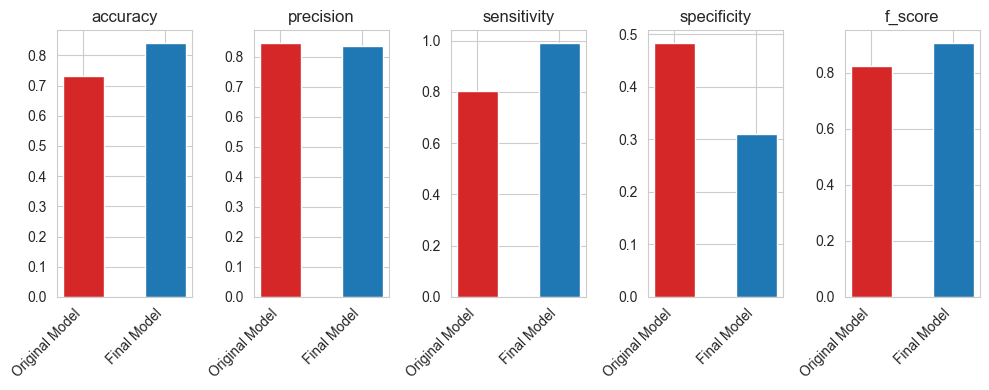

In [46]:
import matplotlib.pyplot as plt

# calculate accuracy, precision, sensitivity, specificity, and f-Score for each confusion matrix
# plot all the result into a graph
def calculate_stats(confusion_matrix):
    """
    Description: A function that automatically calculate 5 essential statistics
    
    Input: 
    confusion_matrix: A 2 by 2 dataframe. It's a confusion matrix with row being 
    actual and column being predicted.
    
    Output: 
    result: A dictionary of essential statistics, including accuracy, precision, sensitivity, 
    specificity, f score. 
    """
    result = {}

    result['TN'] = tn = confusion_matrix.iloc[0, 0]
    result['FP'] = fp = confusion_matrix.iloc[0, 1]
    result['FN'] = fn = confusion_matrix.iloc[1, 0]
    result['TP'] = tp = confusion_matrix.iloc[1, 1]

    result['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    result['precision'] = precision = tp / (tp + fp)
    result['sensitivity'] = sensitivity = tp / (tp + fn)
    result['specificity'] = tn / (tn + fp)
    result['f_score'] = 2 * (precision * sensitivity) / (precision + sensitivity)

    return result


stats_01 = calculate_stats(confusion_matrix_005_ori)
stats_02 = calculate_stats(confusion_matrix_005_mass)

plt.figure(figsize=(10, 4)) 
x = [1, 2]
labels = ['accuracy', 'precision', 'sensitivity', 'specificity', 'f_score']
for i, key in enumerate(labels):
    y = [stats_01[key], stats_02[key]]
    plt.subplot(1, 5, i + 1)
    plt.bar(x, y, width=0.5, color=['tab:red', 'tab:blue'])
    plt.title(key)
    plt.xticks(x, ['Original Model', 'Final Model'], rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Testability of the model

In [47]:
agreed_bio_data

,index,activity,chemical,category,moa,bigg,exchange,model_simulation_0.05_model_ori,model_simulation_0.05
0,PM01_A01,False,Negative Control,carbon,"C-Source, negative control",#,#,NaN,NaN
1,PM01_A02,True,L-Arabinose,carbon,"C-Source, carbohydrate",arab__L,EX_arab__L_e,False,True
2,PM01_A03,True,N-Acetyl-D-Glucosamine,carbon,"C-Source, carbohydrate",acgam,EX_acgam_e,NaN,NaN
3,PM01_A04,False,D-Saccharic acid,carbon,"C-Source, carboxylic acid",glcr,EX_glcr_e,NaN,NaN
4,PM01_A05,True,Succinic acid,carbon,"C-Source, carboxylic acid",succ,EX_succ_e,True,True
...,...,...,...,...,...,...,...,...,...
379,PM04_H08,False,p-Aminobenzene Sulfonic acid,phosphate & sulphur,"S-Source, organic",4abz,EX_4abz_e,NaN,NaN
380,PM04_H09,False,Butane Sulfonic acid,phosphate & sulphur,"S-Source, organic",butso3,EX_butso3_e,NaN,NaN
381,PM04_H10,False,2-Hydroxyethane Sulfonic acid,phosphate & sulphur,"S-Source, organic",isetac,EX_isetac_e,NaN,NaN
382,PM04_H11,False,Methane Sulfonic acid,phosphate & sulphur,"S-Source, organic",mso3,EX_mso3_e,NaN,NaN


In [48]:
# Find out the testable & untestable number of sources from simulation
for element in "CNPS":
    num1 = len(
        agreed_bio_data[
            (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
            & ~(agreed_bio_data.xs("model_simulation_0.05_model_ori", axis=1).isna())
        ]
    )
    num2 = len(
        agreed_bio_data[
            (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
            & (agreed_bio_data.xs("model_simulation_0.05", axis=1).isna())
        ]
    )
    print(f"{element}-sources: Number of computationally testable: {num1} and untestable: {num2}")

C-sources: Number of computationally testable: 68 and untestable: 124
N-sources: Number of computationally testable: 44 and untestable: 51
P-sources: Number of computationally testable: 15 and untestable: 45
S-sources: Number of computationally testable: 4 and untestable: 32


In [49]:
# Find out the untestable ones
count = 0
for element in "CNPS":
    chemicals = agreed_bio_data[
        (agreed_bio_data.xs("moa", axis=1).str.startswith(f"{element}-Source"))
        & (agreed_bio_data.xs("model_simulation_0.05", axis=1).isna())
        & (agreed_bio_data.xs("activity", axis=1))
    ]["chemical"].unique()
    count += len(chemicals)
    
    print(f"{element}-sources: \nUntestable chemicals with positive growth in experiment: \n{chemicals}\n")
print(count)

C-sources: 
Untestable chemicals with positive growth in experiment: 
['N-Acetyl-D-Glucosamine' 'DL-Malic acid' 'Tween 20' 'D-Glucosaminic acid'
 'Tween 40' 'a-Ketobutyric acid' 'Tween 80' 'a-Hydroxybutyric acid'
 'b-Methyl-D-Glucoside' 'Gly-Asp' 'Bromosuccinic acid' 'Glyoxylic acid'
 'Gly-Glu' 'Ala-Gly' 'Methylpyruvate' 'Gly-Pro'
 'm-Hydroxyphenyl Acetic acid' 'g-Cyclodextrin' 'Dextrin' 'Gelatin'
 'Glycogen' 'Laminarin' 'Amygdalin' 'D-Arabinose' 'Arbutin' 'Gentiobiose'
 'Salicin' 'Butyric acid' 'Caproic acid' 'D-Glucosamine' 'Malonic acid'
 'L-Alaninamide']

N-sources: 
Untestable chemicals with positive growth in experiment: 
['Biuret' 'D-Asparagine' 'D-Valine' 'N-Phthaloyl-L-Glutamic acid'
 'L-Pyroglutamic acid' 'Agmatine' 'b-Phenylethylamine' 'Tyramine'
 'Acetamide' 'Formamide' 'Glucuronamide' 'DL-Lactamide' 'D-Glucosamine'
 'D-Mannosamine' 'N-Acetyl-D-Glucosamine' 'N-Acetyl-D-Galactosamine'
 'N-Acetyl-D-Mannosamine' 'Uric acid' 'Alloxan' 'Allantoin'
 'Parabanic acid' 'DL-a-Amino-N

# Find out false positives & negatives

In [50]:
# Find out the inconsistency between predicted and simulated ones
print(f"False positives (actual false, predicted true):\n")
print(agreed_bio_data[
    ~(agreed_bio_data.xs("activity", axis=1))
    & agreed_bio_data.xs("model_simulation_0.05", axis=1)
    ]["chemical"].unique())



False positives (actual false, predicted true):

['D-Alanine' 'D-Trehalose' 'D-Serine' 'D-Sorbitol'
 'DL-a-Glycerol Phosphate' 'a-Ketoglutaric acid' 'Uridine' 'L-Glutamine'
 'Glycolic acid' '2-Aminoethanol' 'g-Amino-N-Butyric acid'
 'D-Tartaric acid' 'L-Arginine' 'L-Homoserine' 'L-Leucine' 'L-Lysine'
 'L-Ornithine' 'Guanine' 'Cytidine 3`-Monophosphate' 'Sulfate']


In [51]:
print(f"\nFalse negative (actual true, predicted false):\n")
agreed_bio_data_nan_drop = agreed_bio_data[agreed_bio_data['model_simulation_0.05'].notna()]
false_negative = agreed_bio_data_nan_drop[
    agreed_bio_data_nan_drop.xs("activity", axis=1)
    & ~(agreed_bio_data_nan_drop.xs("model_simulation_0.05", axis=1))
    ]["chemical"].unique()

print(false_negative)


False negative (actual true, predicted false):

['L-Methionine']


In [ ]:
with model_mass:
    model.medium['EX_gl']

# Compare all the models

In [28]:

import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with your data
df = pd.read_excel("model_comparison.xlsx")

df

,Model,False Positive,True Positive,False Negative,True Negative,Total,Accuracy,Precision,Sensitivity,F1 Score
0,Original,15,82,20,14,131,0.732824,0.845361,0.803922,0.824121
1,Update with Sco-GEM,17,95,8,12,132,0.810606,0.848214,0.922330,0.883721
2,Update with Universal Model,26,103,0,3,132,0.803030,0.798450,1.000000,0.887931
3,Biosustain,20,102,1,9,132,0.840909,0.836066,0.990291,0.906667


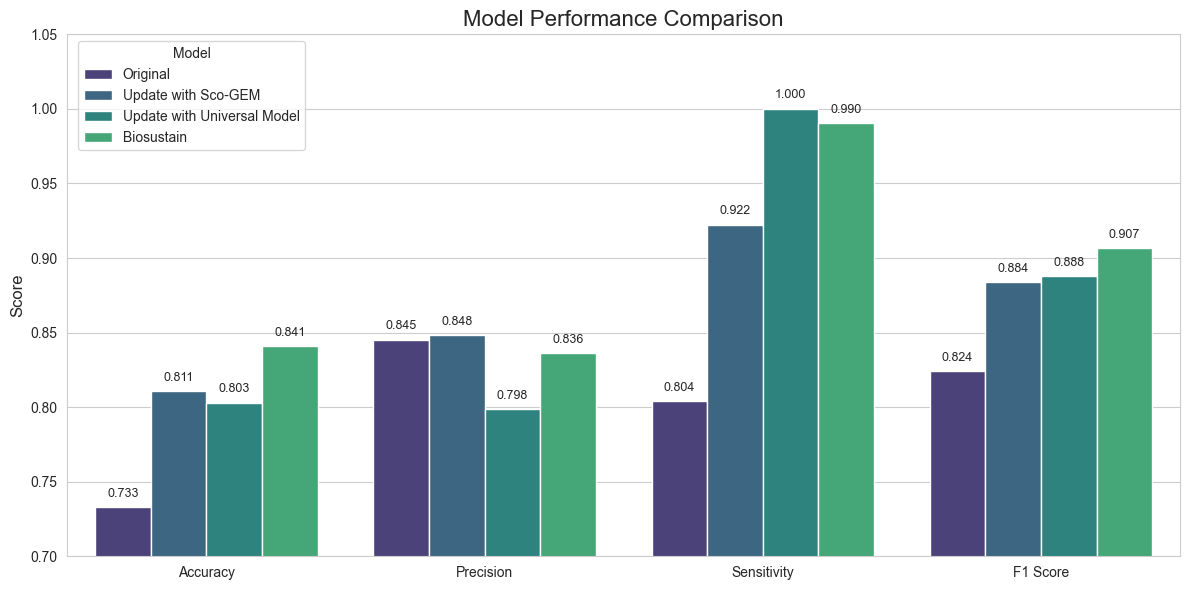

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to long format for seaborn
df_long = pd.melt(df, id_vars=['Model'], 
                 value_vars=['Accuracy', 'Precision', 'Sensitivity', 'F1 Score'],
                 var_name='Metric', value_name='Value')

# Set up a color palette that clearly distinguishes between models
palette = sns.color_palette("viridis", 5)

# Create the plot with seaborn
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create the grouped bar plot
ax = sns.barplot(
    data=df_long,
    x="Metric", y="Value", hue="Model",
    palette=palette
)

# Customize the plot
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0.7, 1.05)

# Add value labels on top of bars - compatible with older matplotlib versions
for container in ax.containers:
    bars = container.get_children()
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.005, 
            f'{height:.3f}', 
            ha='center', 
            va='bottom',
            fontsize=9
        )

# Add a legend with a better position
ax.legend(title='Model', bbox_to_anchor=(0.22, 1))

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("model_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

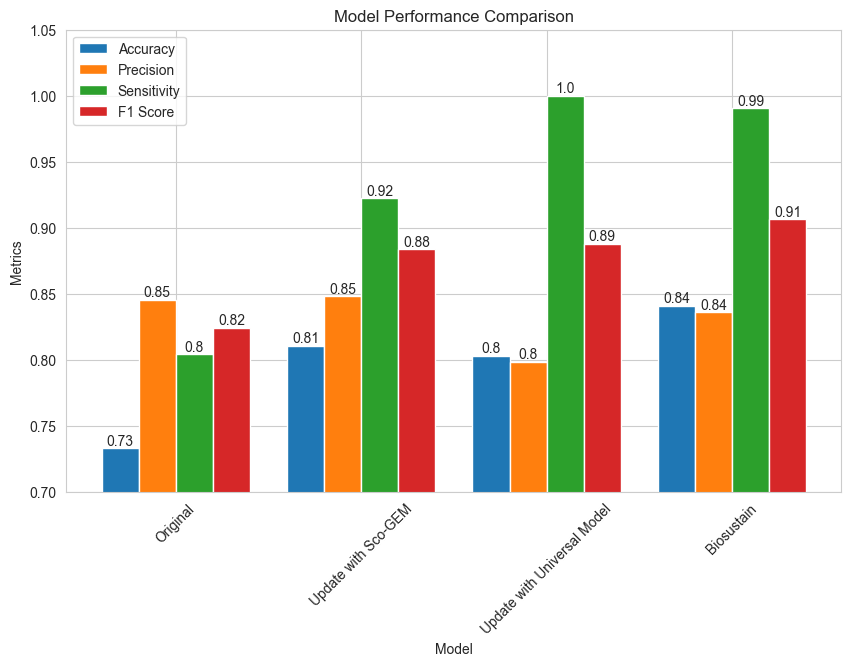

In [30]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

width = 0.2  # width of the bars

# Setting the positions of the bars
positions = list(range(len(df['Model'])))
positions_precision = [x + width for x in positions]
positions_sensitivity = [x + width * 2 for x in positions]
positions_f1 = [x + width * 3 for x in positions]

# Creating the bar plots
bars1 = ax.bar(positions, df['Accuracy'], width, label='Accuracy')
bars2 = ax.bar(positions_precision, df['Precision'], width, label='Precision')
bars3 = ax.bar(positions_sensitivity, df['Sensitivity'], width, label='Sensitivity')
bars4 = ax.bar(positions_f1, df['F1 Score'], width, label='F1 Score')

# Adding labels on top of the bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Metrics')
ax.set_title('Model Performance Comparison')
ax.set_xticks([p + width * 1.5 for p in positions])
ax.set_xticklabels(df['Model'])

# Adding a legend
ax.legend()

# Display the plot with guidelines
plt.xticks(rotation=45)
plt.ylim(0.7, 1.05)
plt.show()

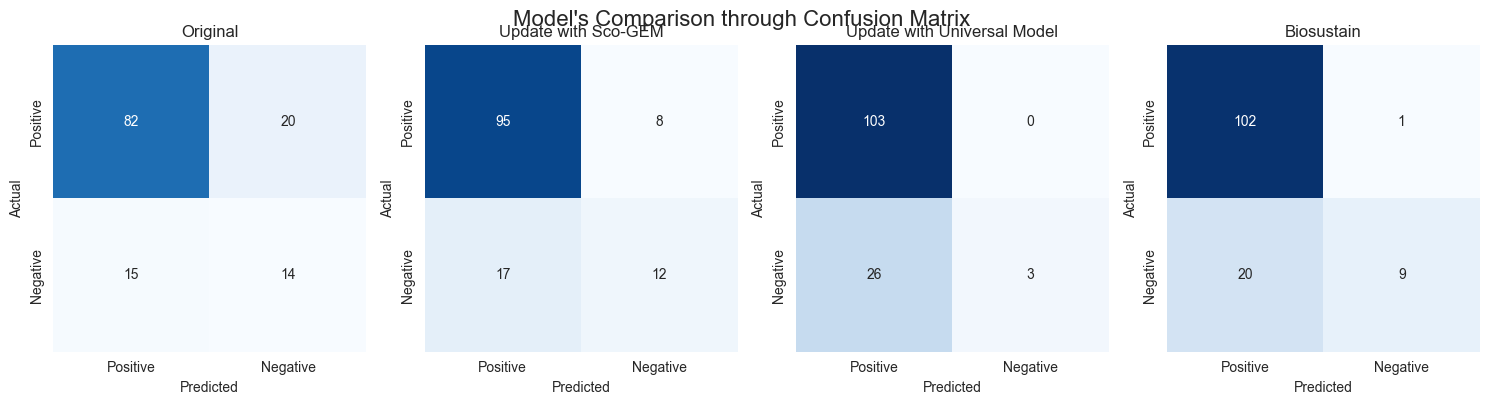

In [31]:
import seaborn as sns 

# Number of models
num_models = len(df)

# Finding the maximum value across all confusion matrices for a consistent color scale
max_value = df[['False Positive', 'True Positive', 'False Negative', 'True Negative']].values.max()

# Creating a subplot for each model's confusion matrix
fig, axes = plt.subplots(1, num_models, figsize=(15,4))

for i, ax in enumerate(axes.flat):
    # Extracting confusion matrix data for each model
    cm_data = [[df.iloc[i]['True Positive'], df.iloc[i]['False Negative']],
               [df.iloc[i]['False Positive'], df.iloc[i]['True Negative']]]
    
    # Creating a heatmap for the confusion matrix with a consistent color scale
    sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', vmax=max_value, ax=ax, cbar=False)

    # Adding titles and labels
    ax.set_title(df['Model'][i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(['Positive', 'Negative'])
    ax.yaxis.set_ticklabels(['Positive', 'Negative'])

# Main title for the entire figure
plt.suptitle("Model's Comparison through Confusion Matrix ", fontsize=16, y=1.0)

# Adjust layout
plt.tight_layout()
plt.show()
